In [1]:
!nvidia-smi

Fri Jul  9 21:25:27 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.80.02    Driver Version: 450.80.02    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  On   | 00000000:04:00.0 Off |                  N/A |
| 23%   31C    P8     8W / 250W |      1MiB / 11178MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  On   | 00000000:05:00.0 Off |                  N/A |
| 23%   

In [32]:
#pip3 install -U h5py==2.9.0
#pip3 install -U gast==0.4.0
#!pip3 install -U scikit-learn==0.20
#!pip3 install -U attention

  Using cached scikit_learn-0.20.0-cp36-cp36m-manylinux1_x86_64.whl (5.3 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pytorch-forecasting 0.9.0 requires scikit-learn<0.25,>=0.23, but you have scikit-learn 0.20.0 which is incompatible.
You should consider upgrading via the '/homedtic/jrafael/anaconda3/envs/deeplung/bin/python -m pip install --upgrade pip' command.


In [2]:
#!pip3 install -U jupyter

In [3]:
#!pip3 install -U nomkl

ERROR: Could not find a version that satisfies the requirement nomkl (from versions: none)
ERROR: No matching distribution found for nomkl


In [1]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from pickle import dump,load

In [2]:
import os
import time
import requests
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

In [3]:
from sodapy import Socrata

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Lambda, Dot, Activation, Concatenate, Layer
from attention import Attention

In [5]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
            
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
        
    return agg

In [6]:
#Load data

In [7]:
!mkdir data_flow

mkdir: cannot create directory ‘data_flow’: File exists


In [8]:
#COLLECT DATA

In [9]:
#Incidencia - Regio

In [6]:
from datetime import datetime
#today = datetime.today().strftime('%Y-%m-%d')
today = "2021-05-27"
print(today)

2021-05-27


In [ ]:
# Unauthenticated client only works with public data sets. Note 'None'
# in place of application token, and no username or password:
client = Socrata("analisi.transparenciacatalunya.cat", None)

# Example authenticated client (needed for non-public datasets):
# client = Socrata(analisi.transparenciacatalunya.cat,
#                  MyAppToken,
#                  userame="user@example.com",
#                  password="AFakePassword")

# First 2000 results, returned as JSON from API / converted to Python list of
# dictionaries by sodapy.
results = client.get("dmzh-fz47",limit=1000000) #623z-r97q

# Convert to pandas DataFrame
results_df = pd.DataFrame.from_records(results)
print(results_df.shape)

In [ ]:
print(results_df.columns)
results_df["data"] = pd.to_datetime(results_df["data"])

#Ingressats_critic -> UCI (ocupat)
#Ingressats_total -> Planta+UCI (ocupat)


results_df["casos_confirmat"] = pd.to_numeric(results_df["casos_confirmat"])
results_df["ingressos_critic"] = pd.to_numeric(results_df["ingressos_critic"])
results_df["ingressos_total"] = pd.to_numeric(results_df["ingressos_total"])
results_df["ingressats_critic"] = pd.to_numeric(results_df["ingressats_critic"])
results_df["ingressats_total"] = pd.to_numeric(results_df["ingressats_total"])

#results_df.sort_values("data",ascending=True).tail()
dfCasosReg = results_df[["data","nom","codi","casos_confirmat",
                         "ingressos_critic","ingressos_total",
                         "ingressats_critic","ingressats_total"
                         ]].groupby([
    "data","nom","codi"]).sum() #
print(dfCasosReg.columns)
dfCasosReg = dfCasosReg.reset_index()
print(dfCasosReg.shape)
dfCasosReg.tail(50)

In [71]:
mapRegId =  {'0000': 'No classificat',
 '7803': 'BARCELONA CIUTAT',
 '6700': 'CATALUNYA CENTRAL',
 '7801': 'METROPOLITANA SUD',
 '6400': 'GIRONA', #ok
 '7802': 'METROPOLITANA NORD',
 '6200': 'CAMP DE TARRAGONA',
 '6100': 'LLEIDA',
 '7100': 'ALT PIRINEU I ARAN',
 '6300': "TERRES DE L'EBRE"}

In [88]:
regions={
"7100":[1,2,3,4,37,103,169,174,179,180,233,259],
"7803":[16,17,18,20,71,72,73,74,75,76,77,78,79,331,39,40,41,32,34,36,38,381,
        400,42,43,44,45,46,21,23,27,28,29,31,47,358,
        326,327,385,402,403,70,395,396],
"7801":[24,25,61,62,63,64,65,176,218,235,316,317,359,380,393,394,397,398,108,109,110,111,116,117,122,123,
        160,182,183,184,202,203,204,205,209,210,213,214,216,261,265,266,288,289,290,291,
        292,293,294,295,296,297,298,299,368,369,370,
        374,378,379,401,115,149,168,201,360,365,367],
"7802":[10,30,33,35,55,66,67,68,69,152,153,154,155,156,157,158,186,222,223,224,225,226,271,272,273,274,275,
        276,277,279,280,281,282,283,311,312,319,335,341,342,353,361,362,366,97,104,105,190,
        191,192,193,194,196,197,198,320,322,344,345,382,383,384,386,387,392,247,248,249,250,
        251,252,309,310,356,363,377,388,389,390,399,89,95,121,150,164,175,207,230,284,285,
        286,
        287,300,315,348,349,355,373,391],
"6200":[6,7,8,9,48,162,262,263,333,13,107,166,239,240,241,242,243,244,257,314,339,340,350,357,364,
        87,91, 112,118,163,188,303,304,306,305,307,324,354],
"6700":[19,22,59,60,88,131,228,229,269,337,338,371,372,102,144,185,212,217,238,253,254,351,352,376,11,
        82,96,98,128,130,145,146,147,148,159,167,200,211,215,219,236,237],
"6400":[51,52,53,54,56,57,58,80,83,84,92,114,119,133,134,171,172,173,177,187,189,208,258,267,343,346,347,
        15,85,90,93,100,101,124,125,126,127,142,143,199,221,231,234,325,330,336],
"6100":[5,12,14,81,86,106,129,135,136,137,138,139,140,141,161,181,232,245,329,334,375],
"6300":[49,50,113,120,165,178,206,246,255,256,260,328]
}

In [89]:
#Validation

In [91]:
total = 0
for r1 in dfCasosReg.codi.unique():
    print(r1)
    for r in regions.keys():
        if (int(r1) in regions[r]):
            print("Found " + str(r1) + " in " + mapRegId[str(r)] + " name: " + 
                  dfCasosReg[dfCasosReg["codi"]==r1]["nom"].unique())


6
['Found 6 in CAMP DE TARRAGONA name: ALT CAMP I CONCA DE BARBERÀ']
51
['Found 51 in GIRONA name: ALT EMPORDÀ']
55
['Found 55 in METROPOLITANA NORD name: ALT MARESME']
61
['Found 61 in METROPOLITANA SUD name: ALT PENEDÈS']
1
['Found 1 in ALT PIRINEU I ARAN name: ALT URGELL']
37
['Found 37 in ALT PIRINEU I ARAN name: ALTA RIBAGORÇA']
48
['Found 48 in CAMP DE TARRAGONA name: ALTEBRAT']
19
['Found 19 in CATALUNYA CENTRAL name: ANOIA']
4
['Found 4 in ALT PIRINEU I ARAN name: ARAN']
59
['Found 59 in CATALUNYA CENTRAL name: BAGES I SOLSONÈS']
7
['Found 7 in CAMP DE TARRAGONA name: BAIX CAMP I PRIORAT']
49
["Found 49 in TERRES DE L'EBRE name: BAIX EBRE"]
52
['Found 52 in GIRONA name: BAIX EMPORDÀ']
24
["Found 24 in METROPOLITANA SUD name: BAIX LLOBREGAT CENTRE I FONTSANTA -L'H N"]
64
['Found 64 in METROPOLITANA SUD name: BAIX LLOBREGAT LITORAL I SANT BOI']
63
['Found 63 in METROPOLITANA SUD name: BAIX LLOBREGAT LITORAL I VILADECANS']
65
['Found 65 in METROPOLITANA SUD name: BAIX LLOBREGAT NO

In [92]:
dfCasosReg["codi"] = pd.to_numeric(dfCasosReg["codi"])
dfCasosReg["regiosanitariacodi"] = -1
for reg in regions.keys():
    for r in regions[reg]:
        dfCasosReg["regiosanitariacodi"].loc[dfCasosReg["codi"].values == r] = reg
    
#Save
dfCasosReg.to_csv("data_flow/CASOS_UCI" + today +".csv",index=False)
print(dfCasosReg.shape)
dfCasosReg.loc[dfCasosReg["regiosanitariacodi"]==-1][["nom","codi","regiosanitariacodi"]]

/home/xavier.rafael/PROGRAMS/anaconda3/envs/covid19CAT/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


(21758, 9)


,nom,codi,regiosanitariacodi


In [64]:
#Vacunacio - Regio

In [66]:
# Unauthenticated client only works with public data sets. Note 'None'
# in place of application token, and no username or password:
client = Socrata("analisi.transparenciacatalunya.cat", None)

# Example authenticated client (needed for non-public datasets):
# client = Socrata(analisi.transparenciacatalunya.cat,
#                  MyAppToken,
#                  userame="user@example.com",
#                  password="AFakePassword")

# First 2000 results, returned as JSON from API / converted to Python list of
# dictionaries by sodapy.
results = client.get("tp23-dey4",limit=10000000) #623z-r97q

In [93]:
#'BioNTech / Pfizer' 'No administrada' 'Moderna / Lonza'
#'Oxford / AstraZeneca' 'J&J / Janssen'
fabDosi = dict()
fabDosi["BioNTech / Pfizer"] = 2
fabDosi["Moderna / Lonza"] = 2
fabDosi["Oxford / AstraZeneca"] = 2
fabDosi["J&J / Janssen"] = 1

In [96]:
# Convert to pandas DataFrame
results_df = pd.DataFrame.from_records(results)
results_df["regio_codi"][results_df["regio_codi"].isnull()] = 0

print(results_df.columns)
print(results_df.shape)
print(results_df["regio"].unique())
print(results_df["regio_codi"].unique())
print(results_df["fabricant"].unique())
print(results_df["dosi"].unique())

Index(['sexe_codi', 'sexe', 'regio_codi', 'regio', 'sector_codi', 'sector',
       'aga_codi', 'aga', 'abs_codi', 'abs', 'edat', 'dosi', 'data',
       'fabricant', 'recompte', 'no_vacunat'],
      dtype='object')
(1600592, 16)
['BARCELONA CIUTAT' 'METROPOLITANA NORD' 'METROPOLITANA SUD' 'GIRONA'
 'CATALUNYA CENTRAL' 'CAMP DE TARRAGONA' 'LLEIDA' "TERRES DE L'EBRE"
 'ALT PIRINEU I ARAN' 'No classificat']
['7803' '7802' '7801' '6400' '6700' '6200' '6100' '6300' '7100' 0]
['Moderna / Lonza' 'BioNTech / Pfizer' 'Oxford / AstraZeneca'
 'No administrada' 'J&J / Janssen']
['1' '2']


In [97]:
results_df["no_vacunat"][results_df["no_vacunat"].isnull()] = 0
results_df["no_vacunat"][results_df["no_vacunat"]!=0] = 1

print(results_df["no_vacunat"].unique())

results_df["data"] = pd.to_datetime(results_df["data"])
results_df["recompte"] = pd.to_numeric(results_df["recompte"])
results_df["dosi"] = pd.to_numeric(results_df["dosi"])
results_df["no_vacunat"] = pd.to_numeric(results_df["no_vacunat"])

dfCasosVac = results_df[["data","regio_codi","regio","dosi","no_vacunat","recompte"]].groupby([
    "data","regio_codi","regio","dosi","no_vacunat"]).sum()
print(dfCasosVac.shape)
dfCasosVac = dfCasosVac.reset_index()
dfCasosVac = dfCasosVac[dfCasosVac["no_vacunat"]==0]
dfCasosVac.to_csv("data_flow/CASOS_VAC" + today +".csv",index=False)
print(dfCasosVac.shape)
dfCasosVac

[0 1]
(6270, 1)
(3667, 6)


,data,regio_codi,regio,dosi,no_vacunat,recompte
0,2020-12-27,0,No classificat,1,0,1
1,2020-12-27,6100,LLEIDA,1,0,66
3,2020-12-27,6200,CAMP DE TARRAGONA,1,0,112
4,2020-12-27,6300,TERRES DE L'EBRE,1,0,82
5,2020-12-27,6400,GIRONA,1,0,76
...,...,...,...,...,...,...
6260,2021-07-19,7801,METROPOLITANA SUD,2,0,8879
6262,2021-07-19,7802,METROPOLITANA NORD,1,0,3559
6264,2021-07-19,7802,METROPOLITANA NORD,2,0,11807
6266,2021-07-19,7803,BARCELONA CIUTAT,1,0,3966


In [98]:
dfCasosVac["regio_codi"].unique()

array([0, '6100', '6200', '6300', '6400', '6700', '7100', '7801', '7802',
       '7803'], dtype=object)

In [99]:
dfCasosVac["regio"].unique()

array(['No classificat', 'LLEIDA', 'CAMP DE TARRAGONA',
       "TERRES DE L'EBRE", 'GIRONA', 'CATALUNYA CENTRAL',
       'ALT PIRINEU I ARAN', 'METROPOLITANA SUD', 'METROPOLITANA NORD',
       'BARCELONA CIUTAT'], dtype=object)

In [100]:
print(dfCasosVac["recompte"][dfCasosVac["no_vacunat"]==1].sum())
print(dfCasosVac["recompte"][dfCasosVac["no_vacunat"]==0].sum())
print(dfCasosVac["recompte"][np.logical_and(dfCasosVac["no_vacunat"]==0,dfCasosVac["dosi"]==1)].sum())
print(dfCasosVac["recompte"][np.logical_and(dfCasosVac["no_vacunat"]==0,dfCasosVac["dosi"]==2)].sum())

0
8439136
4780008
3659128


In [ ]:
#LOAD

In [6]:
#today = "2021-05-27" #TRAIN
#today = "2021-12-02"
today = "2022-03-02"

In [7]:
#Vacunats

In [8]:
dfVac = pd.read_csv("data_flow/CASOS_VAC" + today + ".csv")

print(dfVac.shape)
print(dfVac.columns)

print(dfVac["regio_codi"].unique())
print(dfVac["regio"].unique())
print(dfVac["data"].iloc[-5:])
print((dfVac["regio_codi"]==0).sum())
print(dfVac["dosi"].unique())

dfVac["recompte"] = pd.to_numeric(dfVac["recompte"])
dfVac["data"] = pd.to_datetime(dfVac["data"])
dfVac.sort_values("data",ascending=True, inplace=True)

print(dfVac[dfVac["regio_codi"]==7803].shape)
#dfVac[dfVac["regio_codi"]==7803][["data","recompte"]].plot(x="data",y="recompte") #BCN CENTRE
#dfVac[dfVac["regio_codi"]==7801][["data","recompte"]].plot(x="data",y="recompte") #BCN SUD
#dfVac[dfVac["regio_codi"]==7802][["data","recompte"]].plot(x="data",y="recompte") #BCN NORD


(9539, 6)
Index(['data', 'regio_codi', 'regio', 'dosi', 'no_vacunat', 'recompte'], dtype='object')
[6100 6200 6300 6400 6700 7100 7801 7802 7803    0]
['LLEIDA' 'CAMP DE TARRAGONA' "TERRES DE L'EBRE" 'GIRONA'
 'CATALUNYA CENTRAL' 'ALT PIRINEU I ARAN' 'METROPOLITANA SUD'
 'METROPOLITANA NORD' 'BARCELONA CIUTAT' 'No classificat']
9534    2022-02-28
9535    2022-02-28
9536    2022-02-28
9537    2022-02-28
9538    2022-02-28
Name: data, dtype: object
935
[1 2 3]
(997, 6)


In [9]:
# calculate cases by computing the mean of the last 7 days reported cases

dfVac_r_6200_v1 = dfVac[np.logical_and(dfVac["regio_codi"]==6200, dfVac["dosi"]==1)][["data","recompte"]]
dfVac_r_6200_v2 = dfVac[np.logical_and(dfVac["regio_codi"]==6200, dfVac["dosi"]==2)][["data","recompte"]]

dfVac_r_7803_v1 = dfVac[np.logical_and(dfVac["regio_codi"]==7803, dfVac["dosi"]==1)][["data","recompte"]]
dfVac_r_7803_v2 = dfVac[np.logical_and(dfVac["regio_codi"]==7803, dfVac["dosi"]==2)][["data","recompte"]]

dfVac_r_6700_v1 = dfVac[np.logical_and(dfVac["regio_codi"]==6700, dfVac["dosi"]==1)][["data","recompte"]]
dfVac_r_6700_v2 = dfVac[np.logical_and(dfVac["regio_codi"]==6700, dfVac["dosi"]==2)][["data","recompte"]]

dfVac_r_7801_v1 = dfVac[np.logical_and(dfVac["regio_codi"]==7801, dfVac["dosi"]==1)][["data","recompte"]]
dfVac_r_7801_v2 = dfVac[np.logical_and(dfVac["regio_codi"]==7801, dfVac["dosi"]==2)][["data","recompte"]]

dfVac_r_6400_v1 = dfVac[np.logical_and(dfVac["regio_codi"]==6400, dfVac["dosi"]==1)][["data","recompte"]]
dfVac_r_6400_v2 = dfVac[np.logical_and(dfVac["regio_codi"]==6400, dfVac["dosi"]==2)][["data","recompte"]]

dfVac_r_7802_v1 = dfVac[np.logical_and(dfVac["regio_codi"]==7802, dfVac["dosi"]==1)][["data","recompte"]]
dfVac_r_7802_v2 = dfVac[np.logical_and(dfVac["regio_codi"]==7802, dfVac["dosi"]==2)][["data","recompte"]]

dfVac_r_6100_v1 = dfVac[np.logical_and(dfVac["regio_codi"]==6100, dfVac["dosi"]==1)][["data","recompte"]]
dfVac_r_6100_v2 = dfVac[np.logical_and(dfVac["regio_codi"]==6100, dfVac["dosi"]==2)][["data","recompte"]]

dfVac_r_7100_v1 = dfVac[np.logical_and(dfVac["regio_codi"]==7100, dfVac["dosi"]==1)][["data","recompte"]]
dfVac_r_7100_v2 = dfVac[np.logical_and(dfVac["regio_codi"]==7100, dfVac["dosi"]==2)][["data","recompte"]]

dfVac_r_6300_v1 = dfVac[np.logical_and(dfVac["regio_codi"]==6300, dfVac["dosi"]==1)][["data","recompte"]]
dfVac_r_6300_v2 = dfVac[np.logical_and(dfVac["regio_codi"]==6300, dfVac["dosi"]==2)][["data","recompte"]]

dfVac_r_0_v1 = dfVac[np.logical_and(dfVac["regio_codi"]==0, dfVac["dosi"]==1)][["data","recompte"]]
dfVac_r_0_v2 = dfVac[np.logical_and(dfVac["regio_codi"]==0, dfVac["dosi"]==2)][["data","recompte"]]

print(dfVac_r_0_v1.shape, dfVac_r_7803_v1.shape,dfVac_r_6700_v1.shape,dfVac_r_7801_v1.shape,
     dfVac_r_6400_v1.shape,dfVac_r_7802_v1.shape,dfVac_r_6200_v1.shape,dfVac_r_6100_v1.shape,
     dfVac_r_7100_v1.shape,dfVac_r_6300_v1.shape)

(413, 2) (426, 2) (421, 2) (423, 2) (418, 2) (426, 2) (413, 2) (398, 2) (380, 2) (398, 2)


In [10]:
dfVacAll = None
dfVacAll = pd.merge(dfVac_r_6200_v1,dfVac_r_7803_v1,how="left", on="data",suffixes=("_r_6200_v1","_r_7803_v1"))

dfVacAll = pd.merge(dfVacAll, dfVac_r_6700_v1,how="left", on="data")
dfVacAll.rename(columns = {'recompte':'recompte_r_6700_v1'}, inplace = True)

dfVacAll = pd.merge(dfVacAll,dfVac_r_7801_v1,how="left", on="data")
dfVacAll.rename(columns = {'recompte':'recompte_r_7801_v1'}, inplace = True)

dfVacAll = pd.merge(dfVacAll,dfVac_r_6400_v1,how="left", on="data")
dfVacAll.rename(columns = {'recompte':'recompte_r_6400_v1'}, inplace = True)

dfVacAll = pd.merge(dfVacAll,dfVac_r_7802_v1,how="left", on="data")
dfVacAll.rename(columns = {'recompte':'recompte_r_7802_v1'}, inplace = True)

dfVacAll = pd.merge(dfVacAll,dfVac_r_0_v1,how="left", on="data")
dfVacAll.rename(columns = {'recompte':'recompte_r_0_v1'}, inplace = True)

dfVacAll = pd.merge(dfVacAll,dfVac_r_6100_v1,how="left", on="data")
dfVacAll.rename(columns = {'recompte':'recompte_r_6100_v1'}, inplace = True)

dfVacAll = pd.merge(dfVacAll,dfVac_r_7100_v1,how="left", on="data")
dfVacAll.rename(columns = {'recompte':'recompte_r_7100_v1'}, inplace = True)

dfVacAll = pd.merge(dfVacAll,dfVac_r_6300_v1,how="left", on="data")
dfVacAll.rename(columns = {'recompte':'recompte_r_6300_v1'}, inplace = True)

In [11]:
#dfVacAll.plot(x="data", figsize=(15,8))

In [12]:
dfVacAll = pd.merge(dfVacAll,dfVac_r_0_v2,how="left", on="data")
dfVacAll.rename(columns = {'recompte':'recompte_r_0_v2'}, inplace = True)
dfVacAll = pd.merge(dfVacAll,dfVac_r_7803_v2,how="left", on="data")
dfVacAll.rename(columns = {'recompte':'recompte_r_7803_v2'}, inplace = True)
dfVacAll = pd.merge(dfVacAll,dfVac_r_6700_v2,how="left", on="data")
dfVacAll.rename(columns = {'recompte':'recompte_r_6700_v2'}, inplace = True)
dfVacAll = pd.merge(dfVacAll,dfVac_r_7801_v2,how="left", on="data")
dfVacAll.rename(columns = {'recompte':'recompte_r_7801_v2'}, inplace = True)
dfVacAll = pd.merge(dfVacAll,dfVac_r_6400_v2,how="left", on="data")
dfVacAll.rename(columns = {'recompte':'recompte_r_6400_v2'}, inplace = True)
dfVacAll = pd.merge(dfVacAll,dfVac_r_7802_v2,how="left", on="data")
dfVacAll.rename(columns = {'recompte':'recompte_r_7802_v2'}, inplace = True)
dfVacAll = pd.merge(dfVacAll,dfVac_r_6200_v2,how="left", on="data")
dfVacAll.rename(columns = {'recompte':'recompte_r_6200_v2'}, inplace = True)
dfVacAll = pd.merge(dfVacAll,dfVac_r_6100_v2,how="left", on="data")
dfVacAll.rename(columns = {'recompte':'recompte_r_6100_v2'}, inplace = True)
dfVacAll = pd.merge(dfVacAll,dfVac_r_7100_v2,how="left", on="data")
dfVacAll.rename(columns = {'recompte':'recompte_r_7100_v2'}, inplace = True)
dfVacAll = pd.merge(dfVacAll,dfVac_r_6300_v2,how="left", on="data")
dfVacAll.rename(columns = {'recompte':'recompte_r_6300_v2'}, inplace = True)

dfVacAll.tail()

,data,recompte_r_6200_v1,recompte_r_7803_v1,recompte_r_6700_v1,recompte_r_7801_v1,recompte_r_6400_v1,recompte_r_7802_v1,recompte_r_0_v1,recompte_r_6100_v1,recompte_r_7100_v1,...,recompte_r_0_v2,recompte_r_7803_v2,recompte_r_6700_v2,recompte_r_7801_v2,recompte_r_6400_v2,recompte_r_7802_v2,recompte_r_6200_v2,recompte_r_6100_v2,recompte_r_7100_v2,recompte_r_6300_v2
408,2022-02-23,44,143.0,72.0,67.0,85.0,103,20.0,46.0,1.0,...,19.0,1127.0,419.0,1222.0,794.0,1245.0,667.0,318.0,28.0,113.0
409,2022-02-24,30,153.0,35.0,83.0,123.0,143,27.0,46.0,10.0,...,16.0,1387.0,514.0,1082.0,969.0,1393.0,508.0,439.0,27.0,194.0
410,2022-02-25,48,195.0,47.0,144.0,92.0,145,15.0,47.0,2.0,...,11.0,1596.0,433.0,1557.0,627.0,1227.0,522.0,320.0,14.0,150.0
411,2022-02-26,60,24.0,NaN,123.0,4.0,141,4.0,NaN,NaN,...,NaN,345.0,24.0,1219.0,15.0,1431.0,524.0,1.0,NaN,32.0
412,2022-02-28,41,68.0,23.0,71.0,30.0,86,7.0,32.0,10.0,...,4.0,929.0,129.0,1079.0,310.0,1168.0,490.0,264.0,28.0,140.0


In [13]:
#NAN
print(len(dfVacAll.columns))
print(dfVacAll.columns)
print(dfVacAll.isnull().sum(axis=0))
dfVacAll.fillna(0,inplace=True)
#dfVacAll = dfVacAll.iloc[10:]
print(dfVacAll.isnull().sum(axis=0))

21
Index(['data', 'recompte_r_6200_v1', 'recompte_r_7803_v1',
       'recompte_r_6700_v1', 'recompte_r_7801_v1', 'recompte_r_6400_v1',
       'recompte_r_7802_v1', 'recompte_r_0_v1', 'recompte_r_6100_v1',
       'recompte_r_7100_v1', 'recompte_r_6300_v1', 'recompte_r_0_v2',
       'recompte_r_7803_v2', 'recompte_r_6700_v2', 'recompte_r_7801_v2',
       'recompte_r_6400_v2', 'recompte_r_7802_v2', 'recompte_r_6200_v2',
       'recompte_r_6100_v2', 'recompte_r_7100_v2', 'recompte_r_6300_v2'],
      dtype='object')
data                   0
recompte_r_6200_v1     0
recompte_r_7803_v1     1
recompte_r_6700_v1     3
recompte_r_7801_v1     2
recompte_r_6400_v1     1
recompte_r_7802_v1     0
recompte_r_0_v1        8
recompte_r_6100_v1    18
recompte_r_7100_v1    36
recompte_r_6300_v1    19
recompte_r_0_v2       43
recompte_r_7803_v2    22
recompte_r_6700_v2    28
recompte_r_7801_v2    22
recompte_r_6400_v2    29
recompte_r_7802_v2    21
recompte_r_6200_v2    31
recompte_r_6100_v2    39
recompte

In [14]:
# calculate cases by computing the mean of the last 7 days reported cases
cols = dfVacAll.columns
print(cols)
for k in range(1,len(cols)):
    zn = []
    for i in range(dfVacAll.shape[0]):
        acc = 0
        for j in range(7):
            if i-j>=0:
                acc += dfVacAll.iloc[i-j,k]
        zn.append(acc/7)

    dfVacAll[cols[k] + "_7"] = zn
    
dfVacAll = dfVacAll[["data",
       'recompte_r_6200_v1', 'recompte_r_7803_v1',
       'recompte_r_6700_v1', 'recompte_r_7801_v1', 'recompte_r_6400_v1',
       'recompte_r_7802_v1', 'recompte_r_0_v1', 'recompte_r_6100_v1',
       'recompte_r_7100_v1', 'recompte_r_6300_v1', 'recompte_r_6200_v2', 
       'recompte_r_7803_v2',
       'recompte_r_6700_v2', 'recompte_r_7801_v2', 'recompte_r_6400_v2',
       'recompte_r_7802_v2', 'recompte_r_0_v2', 'recompte_r_6100_v2',
       'recompte_r_7100_v2', 'recompte_r_6300_v2',       
       'recompte_r_6200_v1_7', 'recompte_r_7803_v1_7',
       'recompte_r_6700_v1_7', 'recompte_r_7801_v1_7', 'recompte_r_6400_v1_7',
       'recompte_r_7802_v1_7', 'recompte_r_0_v1_7', 'recompte_r_6100_v1_7',
       'recompte_r_7100_v1_7', 'recompte_r_6300_v1_7', 'recompte_r_6200_v2_7', 
       'recompte_r_7803_v2_7',
       'recompte_r_6700_v2_7', 'recompte_r_7801_v2_7', 'recompte_r_6400_v2_7',
       'recompte_r_7802_v2_7', 'recompte_r_0_v2_7', 'recompte_r_6100_v2_7',
       'recompte_r_7100_v2_7', 'recompte_r_6300_v2_7',                  
                    ]]

print(len(dfVacAll.columns))
dfVacAll

Index(['data', 'recompte_r_6200_v1', 'recompte_r_7803_v1',
       'recompte_r_6700_v1', 'recompte_r_7801_v1', 'recompte_r_6400_v1',
       'recompte_r_7802_v1', 'recompte_r_0_v1', 'recompte_r_6100_v1',
       'recompte_r_7100_v1', 'recompte_r_6300_v1', 'recompte_r_0_v2',
       'recompte_r_7803_v2', 'recompte_r_6700_v2', 'recompte_r_7801_v2',
       'recompte_r_6400_v2', 'recompte_r_7802_v2', 'recompte_r_6200_v2',
       'recompte_r_6100_v2', 'recompte_r_7100_v2', 'recompte_r_6300_v2'],
      dtype='object')
41


,data,recompte_r_6200_v1,recompte_r_7803_v1,recompte_r_6700_v1,recompte_r_7801_v1,recompte_r_6400_v1,recompte_r_7802_v1,recompte_r_0_v1,recompte_r_6100_v1,recompte_r_7100_v1,...,recompte_r_6200_v2_7,recompte_r_7803_v2_7,recompte_r_6700_v2_7,recompte_r_7801_v2_7,recompte_r_6400_v2_7,recompte_r_7802_v2_7,recompte_r_0_v2_7,recompte_r_6100_v2_7,recompte_r_7100_v2_7,recompte_r_6300_v2_7
0,2020-12-27,112,58.0,87.0,84.0,76.0,161,0.0,68.0,79.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2020-12-30,173,441.0,295.0,401.0,127.0,648,16.0,364.0,91.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2020-12-31,191,665.0,228.0,231.0,80.0,569,4.0,504.0,112.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,2021-01-02,3,602.0,401.0,111.0,234.0,615,0.0,46.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,2021-01-03,1,0.0,0.0,0.0,0.0,3,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
408,2022-02-23,44,143.0,72.0,67.0,85.0,103,20.0,46.0,1.0,...,468.285714,1122.428571,342.000000,1042.428571,669.285714,1336.000000,17.571429,296.571429,48.571429,95.142857
409,2022-02-24,30,153.0,35.0,83.0,123.0,143,27.0,46.0,10.0,...,479.285714,1166.285714,353.142857,1044.142857,703.142857,1290.571429,16.428571,308.285714,39.857143,104.428571
410,2022-02-25,48,195.0,47.0,144.0,92.0,145,15.0,47.0,2.0,...,495.428571,1211.714286,355.571429,1125.285714,662.714286,1199.857143,14.000000,307.000000,26.000000,100.000000
411,2022-02-26,60,24.0,0.0,123.0,4.0,141,4.0,0.0,0.0,...,479.571429,1026.571429,271.857143,1118.571429,534.857143,1187.857143,10.857143,224.857143,22.714286,85.428571


In [15]:
#Incidence x regio

In [16]:
dfInc = pd.read_csv("data_flow/CASOS_UCI" + today + ".csv")
dfInc.tail()

,data,nom,codi,casos_confirmat,ingressos_critic,ingressos_total,ingressats_critic,ingressats_total,regiosanitariacodi
31428,2022-03-01,SELVA MARÍTIMA,56,21,0,0,3,11,6400
31429,2022-03-01,TARRAGONÈS,9,102,0,4,8,42,6200
31430,2022-03-01,VALLÈS OCCIDENTAL EST,35,107,0,0,15,66,7802
31431,2022-03-01,VALLÈS OCCIDENTAL OEST,66,113,0,0,7,79,7802
31432,2022-03-01,VALLÈS ORIENTAL CENTRAL,69,58,0,0,2,24,7802


In [17]:
#group by date and regiosanitaria
dfInc = dfInc[["data","casos_confirmat","ingressos_critic","ingressos_total","ingressats_critic",
              "ingressats_total","regiosanitariacodi"]]
grp = dfInc.groupby(["data","regiosanitariacodi"]).agg("sum")
dfInc = grp.reset_index()
dfInc

,data,regiosanitariacodi,casos_confirmat,ingressos_critic,ingressos_total,ingressats_critic,ingressats_total
0,2020-03-01,6100,0,0,0,0,0
1,2020-03-01,6200,0,0,0,0,0
2,2020-03-01,6300,0,0,0,0,0
3,2020-03-01,6400,2,0,0,0,0
4,2020-03-01,6700,0,0,0,0,0
...,...,...,...,...,...,...,...
6574,2022-03-01,6700,172,0,0,14,100
6575,2022-03-01,7100,26,0,0,0,8
6576,2022-03-01,7801,365,0,3,26,174
6577,2022-03-01,7802,616,3,0,54,337


In [18]:
print(dfInc.shape)
print(dfInc.columns)
print(dfInc["regiosanitariacodi"].unique())
print(dfInc["data"].iloc[-5:])
print((dfInc["regiosanitariacodi"]==0).sum())


dfInc["casos_confirmat"] = pd.to_numeric(dfInc["casos_confirmat"])
dfInc["ingressos_critic"] = pd.to_numeric(dfInc["ingressos_critic"])
dfInc["ingressos_total"] = pd.to_numeric(dfInc["ingressos_total"])
dfInc["ingressats_critic"] = pd.to_numeric(dfInc["ingressats_critic"])
dfInc["ingressats_total"] = pd.to_numeric(dfInc["ingressats_total"])
dfInc["data"] = pd.to_datetime(dfInc["data"])
dfInc.sort_values("data",ascending=True, inplace=True)

print(dfInc[dfInc["regiosanitariacodi"]==7803].shape)

(6579, 7)
Index(['data', 'regiosanitariacodi', 'casos_confirmat', 'ingressos_critic',
       'ingressos_total', 'ingressats_critic', 'ingressats_total'],
      dtype='object')
[6100 6200 6300 6400 6700 7100 7801 7802 7803]
6574    2022-03-01
6575    2022-03-01
6576    2022-03-01
6577    2022-03-01
6578    2022-03-01
Name: data, dtype: object
0
(731, 7)


In [19]:
# Tranform data
#dfInc_r_0 = dfInc[dfInc["regiosanitariacodi"]==0][["data","ingressats_critic"]]
dfInc_r_7803 = dfInc[dfInc["regiosanitariacodi"]==7803][["data","ingressats_critic"]]
dfInc_r_6700 = dfInc[dfInc["regiosanitariacodi"]==6700][["data","ingressats_critic"]]
dfInc_r_7801 = dfInc[dfInc["regiosanitariacodi"]==7801][["data","ingressats_critic"]]
dfInc_r_6400 = dfInc[dfInc["regiosanitariacodi"]==6400][["data","ingressats_critic"]]
dfInc_r_7802 = dfInc[dfInc["regiosanitariacodi"]==7802][["data","ingressats_critic"]]
dfInc_r_6200 = dfInc[dfInc["regiosanitariacodi"]==6200][["data","ingressats_critic"]]
dfInc_r_6100 = dfInc[dfInc["regiosanitariacodi"]==6100][["data","ingressats_critic"]]
dfInc_r_7100 = dfInc[dfInc["regiosanitariacodi"]==7100][["data","ingressats_critic"]]
dfInc_r_6300 = dfInc[dfInc["regiosanitariacodi"]==6300][["data","ingressats_critic"]]
print(dfInc_r_7803.shape,dfInc_r_6700.shape,dfInc_r_7801.shape)

#dfInc = pd.merge(dfInc_r_0,dfInc_r_7803,how="left", on="data",suffixes=("_r_0","_r_7803"))
dfInc = pd.merge(dfInc_r_7803,dfInc_r_6700,how="left", on="data",suffixes=("_r_7803","_r_6700"))
dfInc = pd.merge(dfInc,dfInc_r_7801,how="left", on="data",suffixes=("_r_6700","_r_7801"))
dfInc = pd.merge(dfInc,dfInc_r_6400,how="left", on="data",suffixes=("_r_7801","_r_6400"))
dfInc = pd.merge(dfInc,dfInc_r_7802,how="left", on="data",suffixes=("_r_6400","_r_7802"))
dfInc = pd.merge(dfInc,dfInc_r_6200,how="left", on="data",suffixes=("_r_7802","_r_6200"))
dfInc = pd.merge(dfInc,dfInc_r_6100,how="left", on="data",suffixes=("_r_6200","_r_6100"))
dfInc = pd.merge(dfInc,dfInc_r_7100,how="left", on="data",suffixes=("_r_6100","_r_7100"))
dfInc = pd.merge(dfInc,dfInc_r_6300,how="left", on="data",suffixes=("_r_7100","_r_6300"))
dfInc = pd.merge(dfInc,dfInc_r_6300,how="left", on="data",suffixes=("_r_6300","_r_6300_1"))

dfInc = dfInc[['data', 'ingressats_critic_r_7803', 'ingressats_critic_r_6700',
       'ingressats_critic_r_7801', 'ingressats_critic_r_6400',
       'ingressats_critic_r_7802', 'ingressats_critic_r_6200',
       'ingressats_critic_r_6100', 'ingressats_critic_r_7100',
       'ingressats_critic_r_6300']]
print(dfInc.shape)
print(dfInc.columns)
dfInc.tail(50)

(731, 2) (731, 2) (731, 2)
(731, 10)
Index(['data', 'ingressats_critic_r_7803', 'ingressats_critic_r_6700',
       'ingressats_critic_r_7801', 'ingressats_critic_r_6400',
       'ingressats_critic_r_7802', 'ingressats_critic_r_6200',
       'ingressats_critic_r_6100', 'ingressats_critic_r_7100',
       'ingressats_critic_r_6300'],
      dtype='object')


,data,ingressats_critic_r_7803,ingressats_critic_r_6700,ingressats_critic_r_7801,ingressats_critic_r_6400,ingressats_critic_r_7802,ingressats_critic_r_6200,ingressats_critic_r_6100,ingressats_critic_r_7100,ingressats_critic_r_6300
681,2022-01-11,77,37,36,59,125,36,21,3,13
682,2022-01-12,82,38,41,60,119,36,22,3,13
683,2022-01-13,84,40,39,59,120,38,21,2,11
684,2022-01-14,88,42,42,60,121,40,20,2,11
685,2022-01-15,89,45,42,58,127,40,18,2,10
686,2022-01-16,87,42,43,62,118,40,18,2,12
687,2022-01-17,81,39,40,59,124,41,17,2,12
688,2022-01-18,86,38,39,52,117,40,20,2,12
689,2022-01-19,83,36,40,52,132,38,22,1,13
690,2022-01-20,84,36,44,54,131,36,22,2,12


<AxesSubplot:xlabel='data'>

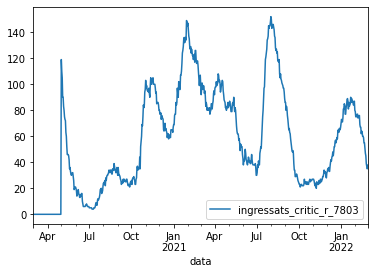

In [20]:
dfInc[["data","ingressats_critic_r_7803"]].plot(x="data")

In [21]:
#NAN
print(dfInc.isnull().sum(axis=0))
dfInc.fillna(0,inplace=True)
print(dfInc.isnull().sum(axis=0))

data                        0
ingressats_critic_r_7803    0
ingressats_critic_r_6700    0
ingressats_critic_r_7801    0
ingressats_critic_r_6400    0
ingressats_critic_r_7802    0
ingressats_critic_r_6200    0
ingressats_critic_r_6100    0
ingressats_critic_r_7100    0
ingressats_critic_r_6300    0
dtype: int64
data                        0
ingressats_critic_r_7803    0
ingressats_critic_r_6700    0
ingressats_critic_r_7801    0
ingressats_critic_r_6400    0
ingressats_critic_r_7802    0
ingressats_critic_r_6200    0
ingressats_critic_r_6100    0
ingressats_critic_r_7100    0
ingressats_critic_r_6300    0
dtype: int64


In [22]:
# calculate cases by computing the mean of the last 7 days reported cases
cols = [
       'data',
       'ingressats_critic_r_7803', 'ingressats_critic_r_6700',
       'ingressats_critic_r_7801', 'ingressats_critic_r_6400',
       'ingressats_critic_r_7802', 'ingressats_critic_r_6200',
       'ingressats_critic_r_6100', 'ingressats_critic_r_7100',
       'ingressats_critic_r_6300'
]
print(cols)
dfInc = dfInc[cols]
for k in range(1,len(cols)):
    print(k,cols[k])
    dfInc[cols[k]] = pd.to_numeric(dfInc[cols[k]])
    zn = []
    for i in range(dfInc.shape[0]):
        acc = 0
        for j in range(7):
            if i-j>=0:
                acc += dfInc.iloc[i-j,k]
        zn.append(acc/7)

    dfInc[cols[k] + "_7"] = zn
    
dfInc = dfInc[["data",
               'ingressats_critic_r_7803', 'ingressats_critic_r_6700',
               'ingressats_critic_r_7801', 'ingressats_critic_r_6400', 'ingressats_critic_r_7802',
               'ingressats_critic_r_6200', 'ingressats_critic_r_6100', 'ingressats_critic_r_7100',
               'ingressats_critic_r_6300',
               'ingressats_critic_r_7803_7', 'ingressats_critic_r_6700_7',
               'ingressats_critic_r_7801_7', 'ingressats_critic_r_6400_7', 'ingressats_critic_r_7802_7',
               'ingressats_critic_r_6200_7', 'ingressats_critic_r_6100_7', 'ingressats_critic_r_7100_7',
               'ingressats_critic_r_6300_7']]
print(dfInc.shape)
dfInc

['data', 'ingressats_critic_r_7803', 'ingressats_critic_r_6700', 'ingressats_critic_r_7801', 'ingressats_critic_r_6400', 'ingressats_critic_r_7802', 'ingressats_critic_r_6200', 'ingressats_critic_r_6100', 'ingressats_critic_r_7100', 'ingressats_critic_r_6300']
1 ingressats_critic_r_7803
2 ingressats_critic_r_6700
3 ingressats_critic_r_7801
4 ingressats_critic_r_6400
5 ingressats_critic_r_7802
6 ingressats_critic_r_6200
7 ingressats_critic_r_6100
8 ingressats_critic_r_7100
9 ingressats_critic_r_6300
(731, 19)


,data,ingressats_critic_r_7803,ingressats_critic_r_6700,ingressats_critic_r_7801,ingressats_critic_r_6400,ingressats_critic_r_7802,ingressats_critic_r_6200,ingressats_critic_r_6100,ingressats_critic_r_7100,ingressats_critic_r_6300,ingressats_critic_r_7803_7,ingressats_critic_r_6700_7,ingressats_critic_r_7801_7,ingressats_critic_r_6400_7,ingressats_critic_r_7802_7,ingressats_critic_r_6200_7,ingressats_critic_r_6100_7,ingressats_critic_r_7100_7,ingressats_critic_r_6300_7
0,2020-03-01,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
1,2020-03-02,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
2,2020-03-03,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
3,2020-03-04,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
4,2020-03-05,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,2022-02-25,39,13,31,31,49,16,9,0,8,50.142857,17.714286,33.142857,35.714286,63.000000,17.857143,12.142857,0.0,9.285714
727,2022-02-26,37,13,29,29,49,17,9,0,9,47.000000,16.857143,32.571429,34.000000,59.714286,17.285714,11.428571,0.0,9.285714
728,2022-02-27,35,14,31,30,49,16,9,0,10,44.142857,16.142857,32.428571,32.285714,56.285714,16.714286,10.714286,0.0,9.428571
729,2022-02-28,36,13,28,29,55,16,7,0,8,41.428571,15.285714,31.857143,30.571429,54.142857,16.285714,9.857143,0.0,9.285714


In [23]:
#TRAIN

In [24]:
selCodisReg = ['6100', '6200', '6300', '6400', '6700', '7100', '7801', '7802','7803']

In [25]:
fnamePrefix = "uci_occupancy_best_model_region_shallow_vacc.02122021."

In [ ]:
try:
    all_history = []
    all_min_tr = []
    all_min_val = []

    for cod in selCodisReg:

        print("\nNEW REGION:", cod)

        #Merge data
        start = time.time()
        dfAll = pd.merge(dfInc[["data",'ingressats_critic_r_'+cod,'ingressats_critic_r_'+cod+'_7']],
                         dfVacAll[["data","recompte_r_"+cod+"_v1","recompte_r_"+cod+"_v2",
                                   "recompte_r_"+cod+"_v1_7","recompte_r_"+cod+"_v2_7"]], 
                         how="left",on="data",suffixes=("",""))
        dfAll.fillna(0, inplace=True)

        #Filter dates
        d1 = pd.Timestamp(2021, 11, 28)
        dfAll["data"] = pd.to_datetime(dfAll["data"])
        dfAll = dfAll[dfAll["data"]<=d1]

        #Convert data to format (rows,timepoints,features)
        cols = [
               'ingressats_critic_r_'+cod, 
               'recompte_r_'+cod+'_v1','recompte_r_'+cod+'_v2'
        ]
        ncols=len(cols)
        res = series_to_supervised(dfAll.loc[:,cols].values,21,21)
        rowsTest = 21
        THR = res.shape[0]-rowsTest

        #Patition train/test
        train_X = res.iloc[:THR,:(21*ncols)].values.reshape(-1,21,ncols)
        train_y = res.iloc[:THR,[(21*ncols)+(ncols*i) for i in range(21)]].values.reshape(-1,21)
        test_X = res.iloc[THR:,:(21*ncols)].values.reshape(-1,21,ncols)
        test_y = res.iloc[THR:,[(21*ncols)+(ncols*i) for i in range(21)]].values.reshape(-1,21)   
        fname = fnamePrefix+cod
        print("ROWS:", train_X.shape[0], test_y.shape[0])
        print("DATES (TRAIN):", dfAll.iloc[0,0], dfAll.iloc[train_X.shape[0],0])
        
        # normalize features
        scalers_X = []
        for i in range(train_X.shape[-1]):

            # normalize features
            scaler = MinMaxScaler(feature_range=(0, 1))
            train_X[:,:,i] = scaler.fit_transform(train_X[:,:,i])
            test_X[:,:,i] = scaler.transform(test_X[:,:,i])
            scalers_X.append(scaler)
            dump(scaler, open("models/"+ fname + "_scaler_tr_X_" + str(i)+'.pkl', 'wb'))

        scaler_y = MinMaxScaler(feature_range=(0, 1))
        train_y = scaler_y.fit_transform(train_y.reshape(-1,21))
        test_y = scaler_y.transform(test_y.reshape(-1,21))
        dump(scaler_y, open("models/"+ fname + "_scaler_tr_Y.pkl", 'wb'))    

        """
        print(train_y.shape)
        all_data = np.vstack((train_y,test_y))
        plt.figure(figsize=(15,5))
        plt.plot(train_X[:,-1,2], label="vacc_1")
        plt.plot(all_data[:,-1], label="test")
        plt.plot(train_y[:,-1], label="validation")
        plt.plot(train_y[:len(train_y)-int((len(train_y)*0.1)),-1], label="train")
        plt.legend()
        """
        
        # fit network
        bs=4
        history=[]
        min_tr = []
        min_val = []
        for i in range(5):
            print("Model input shape:", train_X.shape[1:])
            model_input = layers.Input(shape=train_X.shape[1:])
            x = layers.LSTM(100, activation="relu", recurrent_dropout=0.3)(model_input)
            x = layers.Dropout(0.3)(x)
            x = layers.Dense(21)(x)
            model = keras.models.Model(model_input, x)
            print(model.summary())

            opt = keras.optimizers.Adam(learning_rate=0.001) 
            model.compile(loss='mean_squared_error', optimizer=opt,metrics=["mae","mse"])

            # design callbacks
            es = keras.callbacks.EarlyStopping(monitor='val_mae', 
                                               verbose=1, patience=50) 
            reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_mae', factor=0.2, patience=30,verbose=1)
            mc = keras.callbacks.ModelCheckpoint("models/"+ fname + "_" + str(i) +'.h5', 
                                                 monitor='val_mae', 
                                                 verbose=1, save_best_only=True)

            history.append(model.fit(train_X, train_y, epochs=500, batch_size=bs, 
                                callbacks=[es,mc,reduce_lr],
                                validation_split=0.10, verbose=0, shuffle=False)) #20

            ix = np.argmin(history[-1].history.get('val_mae'))
            min_val.append(history[-1].history.get('val_mae')[ix])
            min_tr.append(history[-1].history.get('mae')[ix])


        print("\nMIN TR:",np.mean(min_tr),np.std(min_tr))
        print("MIN VAL:",np.mean(min_val),np.std(min_val))
        print("DURATION:", (time.time()-start)/60.)

        all_history.append(history)
        all_min_tr.append(min_tr)
        all_min_val.append(min_val)
except err:
    print("An exception occurred", err) 


NEW REGION: 6100
ROWS: 576 21
DATES (TRAIN): 2020-03-01 00:00:00 2021-09-28 00:00:00
Model input shape: (21, 3)
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 21, 3)]           0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               41600     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 21)                2121      
Total params: 43,721
Trainable params: 43,721
Non-trainable params: 0
_________________________________________________________________
None

Epoch 00001: val_mae improved from inf to 0.08023, saving model to models/uci_occupancy_best_model_region_shallow_vacc.02122021.6100_0.h


Epoch 00001: val_mae improved from inf to 0.08010, saving model to models/uci_occupancy_best_model_region_shallow_vacc.02122021.6100_2.h5

Epoch 00002: val_mae did not improve from 0.08010

Epoch 00003: val_mae did not improve from 0.08010

Epoch 00004: val_mae did not improve from 0.08010

Epoch 00005: val_mae did not improve from 0.08010

Epoch 00006: val_mae did not improve from 0.08010

Epoch 00007: val_mae did not improve from 0.08010

Epoch 00008: val_mae did not improve from 0.08010

Epoch 00009: val_mae did not improve from 0.08010

Epoch 00010: val_mae did not improve from 0.08010

Epoch 00011: val_mae did not improve from 0.08010

Epoch 00012: val_mae did not improve from 0.08010

Epoch 00013: val_mae did not improve from 0.08010

Epoch 00014: val_mae did not improve from 0.08010

Epoch 00015: val_mae did not improve from 0.08010

Epoch 00016: val_mae did not improve from 0.08010

Epoch 00017: val_mae did not improve from 0.08010

Epoch 00018: val_mae did not improve from 0.


Epoch 00015: val_mae did not improve from 0.07300

Epoch 00016: val_mae did not improve from 0.07300

Epoch 00017: val_mae did not improve from 0.07300

Epoch 00018: val_mae did not improve from 0.07300

Epoch 00019: val_mae did not improve from 0.07300

Epoch 00020: val_mae did not improve from 0.07300

Epoch 00021: val_mae did not improve from 0.07300

Epoch 00022: val_mae did not improve from 0.07300

Epoch 00023: val_mae did not improve from 0.07300

Epoch 00024: val_mae did not improve from 0.07300

Epoch 00025: val_mae did not improve from 0.07300

Epoch 00026: val_mae did not improve from 0.07300

Epoch 00027: val_mae did not improve from 0.07300

Epoch 00028: val_mae did not improve from 0.07300

Epoch 00029: val_mae did not improve from 0.07300

Epoch 00030: val_mae did not improve from 0.07300

Epoch 00031: val_mae did not improve from 0.07300

Epoch 00031: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 00032: val_mae did not improve from 0.07300



Epoch 00026: val_mae did not improve from 0.05760

Epoch 00027: val_mae did not improve from 0.05760

Epoch 00028: val_mae did not improve from 0.05760

Epoch 00029: val_mae did not improve from 0.05760

Epoch 00030: val_mae did not improve from 0.05760

Epoch 00031: val_mae did not improve from 0.05760

Epoch 00031: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 00032: val_mae did not improve from 0.05760

Epoch 00033: val_mae did not improve from 0.05760

Epoch 00034: val_mae did not improve from 0.05760

Epoch 00035: val_mae did not improve from 0.05760

Epoch 00036: val_mae did not improve from 0.05760

Epoch 00037: val_mae did not improve from 0.05760

Epoch 00038: val_mae did not improve from 0.05760

Epoch 00039: val_mae did not improve from 0.05760

Epoch 00040: val_mae did not improve from 0.05760

Epoch 00041: val_mae did not improve from 0.05760

Epoch 00042: val_mae did not improve from 0.05760

Epoch 00043: val_mae did not improve from 0.05760



Epoch 00038: val_mae did not improve from 0.07929

Epoch 00039: val_mae improved from 0.07929 to 0.07806, saving model to models/uci_occupancy_best_model_region_shallow_vacc.02122021.6200_3.h5

Epoch 00040: val_mae improved from 0.07806 to 0.07521, saving model to models/uci_occupancy_best_model_region_shallow_vacc.02122021.6200_3.h5

Epoch 00041: val_mae did not improve from 0.07521

Epoch 00042: val_mae did not improve from 0.07521

Epoch 00043: val_mae improved from 0.07521 to 0.07492, saving model to models/uci_occupancy_best_model_region_shallow_vacc.02122021.6200_3.h5

Epoch 00044: val_mae improved from 0.07492 to 0.07392, saving model to models/uci_occupancy_best_model_region_shallow_vacc.02122021.6200_3.h5

Epoch 00045: val_mae did not improve from 0.07392

Epoch 00046: val_mae improved from 0.07392 to 0.07228, saving model to models/uci_occupancy_best_model_region_shallow_vacc.02122021.6200_3.h5

Epoch 00047: val_mae did not improve from 0.07228

Epoch 00048: val_mae improved


Epoch 00145: val_mae did not improve from 0.04468

Epoch 00146: val_mae did not improve from 0.04468

Epoch 00147: val_mae did not improve from 0.04468

Epoch 00148: val_mae did not improve from 0.04468

Epoch 00149: val_mae did not improve from 0.04468

Epoch 00150: val_mae did not improve from 0.04468

Epoch 00151: val_mae did not improve from 0.04468

Epoch 00152: val_mae did not improve from 0.04468

Epoch 00153: val_mae did not improve from 0.04468

Epoch 00154: val_mae did not improve from 0.04468

Epoch 00154: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.

Epoch 00155: val_mae did not improve from 0.04468

Epoch 00156: val_mae did not improve from 0.04468

Epoch 00157: val_mae did not improve from 0.04468

Epoch 00158: val_mae did not improve from 0.04468

Epoch 00159: val_mae did not improve from 0.04468

Epoch 00160: val_mae did not improve from 0.04468

Epoch 00161: val_mae did not improve from 0.04468

Epoch 00162: val_mae did not improve from 0.04468




Epoch 00038: val_mae did not improve from 0.03658

Epoch 00039: val_mae did not improve from 0.03658

Epoch 00040: val_mae did not improve from 0.03658

Epoch 00041: val_mae did not improve from 0.03658

Epoch 00042: val_mae did not improve from 0.03658

Epoch 00043: val_mae did not improve from 0.03658

Epoch 00044: val_mae did not improve from 0.03658

Epoch 00045: val_mae did not improve from 0.03658

Epoch 00046: val_mae did not improve from 0.03658

Epoch 00047: val_mae did not improve from 0.03658

Epoch 00048: val_mae did not improve from 0.03658

Epoch 00049: val_mae did not improve from 0.03658

Epoch 00050: val_mae did not improve from 0.03658

Epoch 00051: val_mae did not improve from 0.03658
Epoch 00051: early stopping
Model input shape: (21, 3)
Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 21, 3)]           0         
_______________


Epoch 00002: val_mae did not improve from 0.05211

Epoch 00003: val_mae did not improve from 0.05211

Epoch 00004: val_mae did not improve from 0.05211

Epoch 00005: val_mae did not improve from 0.05211

Epoch 00006: val_mae did not improve from 0.05211

Epoch 00007: val_mae did not improve from 0.05211

Epoch 00008: val_mae did not improve from 0.05211

Epoch 00009: val_mae did not improve from 0.05211

Epoch 00010: val_mae did not improve from 0.05211

Epoch 00011: val_mae did not improve from 0.05211

Epoch 00012: val_mae did not improve from 0.05211

Epoch 00013: val_mae did not improve from 0.05211

Epoch 00014: val_mae did not improve from 0.05211

Epoch 00015: val_mae did not improve from 0.05211

Epoch 00016: val_mae did not improve from 0.05211

Epoch 00017: val_mae did not improve from 0.05211

Epoch 00018: val_mae did not improve from 0.05211

Epoch 00019: val_mae did not improve from 0.05211

Epoch 00020: val_mae did not improve from 0.05211

Epoch 00021: val_mae did not i


Epoch 00013: val_mae did not improve from 0.11948

Epoch 00014: val_mae did not improve from 0.11948

Epoch 00015: val_mae did not improve from 0.11948

Epoch 00016: val_mae did not improve from 0.11948

Epoch 00017: val_mae did not improve from 0.11948

Epoch 00018: val_mae did not improve from 0.11948

Epoch 00019: val_mae did not improve from 0.11948

Epoch 00020: val_mae did not improve from 0.11948

Epoch 00021: val_mae did not improve from 0.11948

Epoch 00022: val_mae did not improve from 0.11948

Epoch 00023: val_mae did not improve from 0.11948

Epoch 00024: val_mae did not improve from 0.11948

Epoch 00025: val_mae did not improve from 0.11948

Epoch 00026: val_mae did not improve from 0.11948

Epoch 00027: val_mae did not improve from 0.11948

Epoch 00028: val_mae did not improve from 0.11948

Epoch 00029: val_mae improved from 0.11948 to 0.10472, saving model to models/uci_occupancy_best_model_region_shallow_vacc.02122021.6400_0.h5

Epoch 00030: val_mae did not improve fro


Epoch 00005: val_mae did not improve from 0.09806

Epoch 00006: val_mae did not improve from 0.09806

Epoch 00007: val_mae did not improve from 0.09806

Epoch 00008: val_mae did not improve from 0.09806

Epoch 00009: val_mae did not improve from 0.09806

Epoch 00010: val_mae did not improve from 0.09806

Epoch 00011: val_mae did not improve from 0.09806

Epoch 00012: val_mae did not improve from 0.09806

Epoch 00013: val_mae did not improve from 0.09806

Epoch 00014: val_mae did not improve from 0.09806

Epoch 00015: val_mae did not improve from 0.09806

Epoch 00016: val_mae did not improve from 0.09806

Epoch 00017: val_mae did not improve from 0.09806

Epoch 00018: val_mae did not improve from 0.09806

Epoch 00019: val_mae did not improve from 0.09806

Epoch 00020: val_mae did not improve from 0.09806

Epoch 00021: val_mae did not improve from 0.09806

Epoch 00022: val_mae did not improve from 0.09806

Epoch 00023: val_mae did not improve from 0.09806

Epoch 00024: val_mae did not i


Epoch 00021: val_mae did not improve from 0.10468

Epoch 00022: val_mae did not improve from 0.10468

Epoch 00023: val_mae did not improve from 0.10468

Epoch 00024: val_mae did not improve from 0.10468

Epoch 00025: val_mae did not improve from 0.10468

Epoch 00026: val_mae did not improve from 0.10468

Epoch 00027: val_mae did not improve from 0.10468

Epoch 00028: val_mae did not improve from 0.10468

Epoch 00029: val_mae did not improve from 0.10468

Epoch 00030: val_mae did not improve from 0.10468

Epoch 00031: val_mae did not improve from 0.10468

Epoch 00031: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 00032: val_mae did not improve from 0.10468

Epoch 00033: val_mae did not improve from 0.10468

Epoch 00034: val_mae did not improve from 0.10468

Epoch 00035: val_mae did not improve from 0.10468

Epoch 00036: val_mae did not improve from 0.10468

Epoch 00037: val_mae did not improve from 0.10468

Epoch 00038: val_mae did not improve from 0.10468



Epoch 00031: val_mae did not improve from 0.05758

Epoch 00032: val_mae did not improve from 0.05758

Epoch 00033: val_mae did not improve from 0.05758

Epoch 00033: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 00034: val_mae did not improve from 0.05758

Epoch 00035: val_mae did not improve from 0.05758

Epoch 00036: val_mae did not improve from 0.05758

Epoch 00037: val_mae did not improve from 0.05758

Epoch 00038: val_mae did not improve from 0.05758

Epoch 00039: val_mae did not improve from 0.05758

Epoch 00040: val_mae did not improve from 0.05758

Epoch 00041: val_mae did not improve from 0.05758

Epoch 00042: val_mae did not improve from 0.05758

Epoch 00043: val_mae did not improve from 0.05758

Epoch 00044: val_mae did not improve from 0.05758

Epoch 00045: val_mae did not improve from 0.05758

Epoch 00046: val_mae did not improve from 0.05758

Epoch 00047: val_mae did not improve from 0.05758

Epoch 00048: val_mae did not improve from 0.05758



Epoch 00038: val_mae did not improve from 0.05445

Epoch 00039: val_mae did not improve from 0.05445

Epoch 00040: val_mae did not improve from 0.05445

Epoch 00041: val_mae did not improve from 0.05445

Epoch 00042: val_mae did not improve from 0.05445

Epoch 00043: val_mae did not improve from 0.05445

Epoch 00044: val_mae did not improve from 0.05445

Epoch 00045: val_mae did not improve from 0.05445

Epoch 00046: val_mae did not improve from 0.05445

Epoch 00047: val_mae did not improve from 0.05445

Epoch 00048: val_mae did not improve from 0.05445

Epoch 00049: val_mae did not improve from 0.05445

Epoch 00050: val_mae did not improve from 0.05445

Epoch 00051: val_mae did not improve from 0.05445

Epoch 00052: val_mae did not improve from 0.05445

Epoch 00053: val_mae did not improve from 0.05445
Epoch 00053: early stopping
Model input shape: (21, 3)
Model: "model_23"
_________________________________________________________________
Layer (type)                 Output Shape    


Epoch 00047: val_mae did not improve from 0.05543

Epoch 00048: val_mae did not improve from 0.05543

Epoch 00049: val_mae did not improve from 0.05543

Epoch 00050: val_mae did not improve from 0.05543

Epoch 00051: val_mae did not improve from 0.05543

Epoch 00052: val_mae did not improve from 0.05543
Epoch 00052: early stopping

MIN TR: 0.1735819786787033 0.005175430182448303
MIN VAL: 0.05701507478952408 0.0017991519851604614
DURATION: 39.378155863285066

NEW REGION: 7100
ROWS: 576 21
DATES (TRAIN): 2020-03-01 00:00:00 2021-09-28 00:00:00
Model input shape: (21, 3)
Model: "model_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        [(None, 21, 3)]           0         
_________________________________________________________________
lstm_25 (LSTM)               (None, 100)               41600     
_________________________________________________________________
dropout_25

Model: "model_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        [(None, 21, 3)]           0         
_________________________________________________________________
lstm_26 (LSTM)               (None, 100)               41600     
_________________________________________________________________
dropout_26 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 21)                2121      
Total params: 43,721
Trainable params: 43,721
Non-trainable params: 0
_________________________________________________________________
None

Epoch 00001: val_mae improved from inf to 0.10647, saving model to models/uci_occupancy_best_model_region_shallow_vacc.02122021.7100_1.h5

Epoch 00002: val_mae did not improve from 0.10647

Epoch 00003: val_mae did not improve from 0.10647

Epoch


Epoch 00132: val_mae did not improve from 0.10014

Epoch 00133: val_mae did not improve from 0.10014

Epoch 00134: val_mae did not improve from 0.10014

Epoch 00135: val_mae did not improve from 0.10014

Epoch 00136: val_mae did not improve from 0.10014

Epoch 00137: val_mae did not improve from 0.10014

Epoch 00138: val_mae did not improve from 0.10014

Epoch 00139: val_mae did not improve from 0.10014

Epoch 00140: val_mae did not improve from 0.10014

Epoch 00141: val_mae did not improve from 0.10014

Epoch 00142: val_mae did not improve from 0.10014

Epoch 00143: val_mae did not improve from 0.10014

Epoch 00144: val_mae did not improve from 0.10014

Epoch 00145: val_mae did not improve from 0.10014

Epoch 00146: val_mae did not improve from 0.10014

Epoch 00147: val_mae did not improve from 0.10014

Epoch 00148: val_mae did not improve from 0.10014

Epoch 00149: val_mae did not improve from 0.10014

Epoch 00150: val_mae did not improve from 0.10014

Epoch 00151: val_mae did not i


Epoch 00078: val_mae did not improve from 0.09637

Epoch 00079: val_mae did not improve from 0.09637

Epoch 00080: val_mae did not improve from 0.09637

Epoch 00081: val_mae did not improve from 0.09637

Epoch 00082: val_mae did not improve from 0.09637

Epoch 00083: val_mae did not improve from 0.09637

Epoch 00084: val_mae did not improve from 0.09637

Epoch 00085: val_mae did not improve from 0.09637

Epoch 00086: val_mae did not improve from 0.09637

Epoch 00087: val_mae did not improve from 0.09637

Epoch 00088: val_mae did not improve from 0.09637

Epoch 00089: val_mae did not improve from 0.09637

Epoch 00090: val_mae did not improve from 0.09637

Epoch 00091: val_mae did not improve from 0.09637

Epoch 00092: val_mae did not improve from 0.09637

Epoch 00093: val_mae did not improve from 0.09637

Epoch 00094: val_mae did not improve from 0.09637

Epoch 00095: val_mae did not improve from 0.09637

Epoch 00096: val_mae did not improve from 0.09637

Epoch 00097: val_mae did not i


Epoch 00031: val_mae did not improve from 0.10336

Epoch 00032: val_mae improved from 0.10336 to 0.10231, saving model to models/uci_occupancy_best_model_region_shallow_vacc.02122021.7100_3.h5

Epoch 00033: val_mae did not improve from 0.10231

Epoch 00034: val_mae improved from 0.10231 to 0.09953, saving model to models/uci_occupancy_best_model_region_shallow_vacc.02122021.7100_3.h5

Epoch 00035: val_mae did not improve from 0.09953

Epoch 00036: val_mae did not improve from 0.09953

Epoch 00037: val_mae did not improve from 0.09953

Epoch 00038: val_mae did not improve from 0.09953

Epoch 00039: val_mae did not improve from 0.09953

Epoch 00040: val_mae did not improve from 0.09953

Epoch 00041: val_mae did not improve from 0.09953

Epoch 00042: val_mae did not improve from 0.09953

Epoch 00043: val_mae did not improve from 0.09953

Epoch 00044: val_mae did not improve from 0.09953

Epoch 00045: val_mae did not improve from 0.09953

Epoch 00046: val_mae did not improve from 0.09953



Epoch 00072: val_mae improved from 0.09415 to 0.09234, saving model to models/uci_occupancy_best_model_region_shallow_vacc.02122021.7100_4.h5

Epoch 00073: val_mae did not improve from 0.09234

Epoch 00074: val_mae did not improve from 0.09234

Epoch 00075: val_mae improved from 0.09234 to 0.09231, saving model to models/uci_occupancy_best_model_region_shallow_vacc.02122021.7100_4.h5

Epoch 00076: val_mae did not improve from 0.09231

Epoch 00077: val_mae did not improve from 0.09231

Epoch 00078: val_mae did not improve from 0.09231

Epoch 00079: val_mae did not improve from 0.09231

Epoch 00080: val_mae did not improve from 0.09231

Epoch 00081: val_mae did not improve from 0.09231

Epoch 00082: val_mae did not improve from 0.09231

Epoch 00083: val_mae did not improve from 0.09231

Epoch 00084: val_mae did not improve from 0.09231

Epoch 00085: val_mae did not improve from 0.09231

Epoch 00086: val_mae did not improve from 0.09231

Epoch 00087: val_mae did not improve from 0.09231



Epoch 00003: val_mae did not improve from 0.07340

Epoch 00004: val_mae did not improve from 0.07340

Epoch 00005: val_mae did not improve from 0.07340

Epoch 00006: val_mae did not improve from 0.07340

Epoch 00007: val_mae did not improve from 0.07340

Epoch 00008: val_mae did not improve from 0.07340

Epoch 00009: val_mae did not improve from 0.07340

Epoch 00010: val_mae did not improve from 0.07340

Epoch 00011: val_mae did not improve from 0.07340

Epoch 00012: val_mae did not improve from 0.07340

Epoch 00013: val_mae did not improve from 0.07340

Epoch 00014: val_mae did not improve from 0.07340

Epoch 00015: val_mae did not improve from 0.07340

Epoch 00016: val_mae did not improve from 0.07340

Epoch 00017: val_mae did not improve from 0.07340

Epoch 00018: val_mae did not improve from 0.07340

Epoch 00019: val_mae did not improve from 0.07340

Epoch 00020: val_mae did not improve from 0.07340

Epoch 00021: val_mae did not improve from 0.07340

Epoch 00022: val_mae did not i


Epoch 00015: val_mae did not improve from 0.06894

Epoch 00016: val_mae did not improve from 0.06894

Epoch 00017: val_mae did not improve from 0.06894

Epoch 00018: val_mae did not improve from 0.06894

Epoch 00019: val_mae did not improve from 0.06894

Epoch 00020: val_mae did not improve from 0.06894

Epoch 00021: val_mae did not improve from 0.06894

Epoch 00022: val_mae did not improve from 0.06894

Epoch 00023: val_mae did not improve from 0.06894

Epoch 00024: val_mae did not improve from 0.06894

Epoch 00025: val_mae did not improve from 0.06894

Epoch 00026: val_mae did not improve from 0.06894

Epoch 00027: val_mae did not improve from 0.06894

Epoch 00028: val_mae did not improve from 0.06894

Epoch 00029: val_mae did not improve from 0.06894

Epoch 00030: val_mae did not improve from 0.06894

Epoch 00031: val_mae did not improve from 0.06894

Epoch 00031: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 00032: val_mae did not improve from 0.06894



Epoch 00026: val_mae did not improve from 0.08803

Epoch 00027: val_mae did not improve from 0.08803

Epoch 00028: val_mae did not improve from 0.08803

Epoch 00029: val_mae did not improve from 0.08803

Epoch 00030: val_mae did not improve from 0.08803

Epoch 00031: val_mae did not improve from 0.08803

Epoch 00031: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 00032: val_mae did not improve from 0.08803

Epoch 00033: val_mae did not improve from 0.08803

Epoch 00034: val_mae did not improve from 0.08803

Epoch 00035: val_mae did not improve from 0.08803

Epoch 00036: val_mae did not improve from 0.08803

Epoch 00037: val_mae did not improve from 0.08803

Epoch 00038: val_mae did not improve from 0.08803

Epoch 00039: val_mae did not improve from 0.08803

Epoch 00040: val_mae did not improve from 0.08803

Epoch 00041: val_mae did not improve from 0.08803

Epoch 00042: val_mae did not improve from 0.08803

Epoch 00043: val_mae did not improve from 0.08803



Epoch 00038: val_mae did not improve from 0.09464

Epoch 00039: val_mae did not improve from 0.09464

Epoch 00040: val_mae did not improve from 0.09464

Epoch 00041: val_mae did not improve from 0.09464

Epoch 00042: val_mae did not improve from 0.09464

Epoch 00043: val_mae did not improve from 0.09464

Epoch 00044: val_mae did not improve from 0.09464

Epoch 00045: val_mae improved from 0.09464 to 0.09462, saving model to models/uci_occupancy_best_model_region_shallow_vacc.02122021.7802_2.h5

Epoch 00046: val_mae did not improve from 0.09462

Epoch 00047: val_mae did not improve from 0.09462

Epoch 00048: val_mae did not improve from 0.09462

Epoch 00049: val_mae did not improve from 0.09462

Epoch 00050: val_mae did not improve from 0.09462

Epoch 00051: val_mae did not improve from 0.09462

Epoch 00052: val_mae did not improve from 0.09462

Epoch 00053: val_mae did not improve from 0.09462

Epoch 00054: val_mae did not improve from 0.09462

Epoch 00055: val_mae did not improve fro


Epoch 00064: val_mae did not improve from 0.10844

Epoch 00065: val_mae did not improve from 0.10844

Epoch 00066: val_mae did not improve from 0.10844

Epoch 00067: val_mae did not improve from 0.10844

Epoch 00068: val_mae did not improve from 0.10844

Epoch 00069: val_mae improved from 0.10844 to 0.10063, saving model to models/uci_occupancy_best_model_region_shallow_vacc.02122021.7802_3.h5

Epoch 00070: val_mae did not improve from 0.10063

Epoch 00071: val_mae did not improve from 0.10063

Epoch 00072: val_mae improved from 0.10063 to 0.09998, saving model to models/uci_occupancy_best_model_region_shallow_vacc.02122021.7802_3.h5

Epoch 00073: val_mae improved from 0.09998 to 0.09393, saving model to models/uci_occupancy_best_model_region_shallow_vacc.02122021.7802_3.h5

Epoch 00074: val_mae improved from 0.09393 to 0.09352, saving model to models/uci_occupancy_best_model_region_shallow_vacc.02122021.7802_3.h5

Epoch 00075: val_mae improved from 0.09352 to 0.09025, saving model to


Epoch 00198: val_mae did not improve from 0.05693

Epoch 00199: val_mae did not improve from 0.05693

Epoch 00200: val_mae did not improve from 0.05693

Epoch 00201: val_mae improved from 0.05693 to 0.05098, saving model to models/uci_occupancy_best_model_region_shallow_vacc.02122021.7802_3.h5

Epoch 00202: val_mae did not improve from 0.05098

Epoch 00203: val_mae did not improve from 0.05098

Epoch 00204: val_mae did not improve from 0.05098

Epoch 00205: val_mae did not improve from 0.05098

Epoch 00206: val_mae did not improve from 0.05098

Epoch 00207: val_mae did not improve from 0.05098

Epoch 00208: val_mae did not improve from 0.05098

Epoch 00209: val_mae did not improve from 0.05098

Epoch 00210: val_mae did not improve from 0.05098

Epoch 00211: val_mae did not improve from 0.05098

Epoch 00212: val_mae did not improve from 0.05098

Epoch 00213: val_mae did not improve from 0.05098

Epoch 00214: val_mae did not improve from 0.05098

Epoch 00215: val_mae did not improve fro


Epoch 00004: val_mae did not improve from 0.16610

Epoch 00005: val_mae improved from 0.16610 to 0.14237, saving model to models/uci_occupancy_best_model_region_shallow_vacc.02122021.7803_0.h5

Epoch 00006: val_mae did not improve from 0.14237

Epoch 00007: val_mae did not improve from 0.14237

Epoch 00008: val_mae improved from 0.14237 to 0.13947, saving model to models/uci_occupancy_best_model_region_shallow_vacc.02122021.7803_0.h5

Epoch 00009: val_mae did not improve from 0.13947

Epoch 00010: val_mae did not improve from 0.13947

Epoch 00011: val_mae did not improve from 0.13947

Epoch 00012: val_mae improved from 0.13947 to 0.13354, saving model to models/uci_occupancy_best_model_region_shallow_vacc.02122021.7803_0.h5

Epoch 00013: val_mae did not improve from 0.13354

Epoch 00014: val_mae improved from 0.13354 to 0.12700, saving model to models/uci_occupancy_best_model_region_shallow_vacc.02122021.7803_0.h5

Epoch 00015: val_mae did not improve from 0.12700

Epoch 00016: val_ma


Epoch 00001: val_mae improved from inf to 0.25721, saving model to models/uci_occupancy_best_model_region_shallow_vacc.02122021.7803_1.h5

Epoch 00002: val_mae improved from 0.25721 to 0.16717, saving model to models/uci_occupancy_best_model_region_shallow_vacc.02122021.7803_1.h5

Epoch 00003: val_mae improved from 0.16717 to 0.15308, saving model to models/uci_occupancy_best_model_region_shallow_vacc.02122021.7803_1.h5

Epoch 00004: val_mae improved from 0.15308 to 0.13958, saving model to models/uci_occupancy_best_model_region_shallow_vacc.02122021.7803_1.h5

Epoch 00005: val_mae improved from 0.13958 to 0.13332, saving model to models/uci_occupancy_best_model_region_shallow_vacc.02122021.7803_1.h5

Epoch 00006: val_mae did not improve from 0.13332

Epoch 00007: val_mae did not improve from 0.13332

Epoch 00008: val_mae did not improve from 0.13332

Epoch 00009: val_mae did not improve from 0.13332

Epoch 00010: val_mae did not improve from 0.13332

Epoch 00011: val_mae improved fro

In [30]:
"""
6100
MIN TR: 0.09521657675504684 0.0028878097465190843
MIN VAL: 0.10089148879051209 0.00738370206482739
6200
MIN TR: 0.07927108108997345 0.004290352715846293
MIN VAL: 0.11762529760599136 0.009010354794057403
6300
MIN TR: 0.16804974377155305 0.012578286532430486
MIN VAL: 0.08545893505215645 0.01945427095770297
6400
MIN TR: 0.11709780693054199 0.038799269838260764
MIN VAL: 0.09559978544712067 0.013245612849568255
6700
MIN TR: 0.1337
MIN VAL: 0.0728
7100
MIN TR: 0.1008
MIN VAL: 0.1602
7801
MIN TR: 0.1185
MIN VAL: 0.0897
7802
MIN TR: 0.1142
MIN VAL: 0.0727
7803
MIN TR: 0.0955
MIN VAL: 0.0749
"""

In [ ]:
#TEST

In [ ]:
for i in range(len(all_history)):
    print("\n" + str(i)+" "+str(selCodisReg[i]))
    print("TR: "+ str(np.mean(all_min_tr[i]))+" VAL: "+str(np.mean(all_min_val[i]))+"+/-"+str(np.std(all_min_val[i])))
    print("TR: "+ str(all_min_tr[i]))
    print("VAL: "+ str(all_min_val[i]))
    
np.save("models/results_" + today + ".npy", all_history)

In [ ]:
#Visualization

7803
Index(['data', 'ingressats_critic_r_7803', 'ingressats_critic_r_7803_7',
       'recompte_r_7803_v1', 'recompte_r_7803_v2', 'recompte_r_7803_v1_7',
       'recompte_r_7803_v2_7'],
      dtype='object')
(461, 21, 6) (42, 21, 6)
Loading... models/uci_best_model_region_vacc_mean7.28052021.7803_0.h5
Loading... models/uci_best_model_region_vacc_mean7.28052021.7803_1.h5
Loading... models/uci_best_model_region_vacc_mean7.28052021.7803_2.h5
Loading... models/uci_best_model_region_vacc_mean7.28052021.7803_3.h5
Loading... models/uci_best_model_region_vacc_mean7.28052021.7803_4.h5
(461, 21) (42, 21)


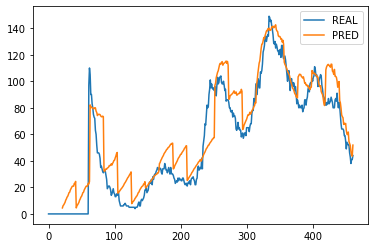

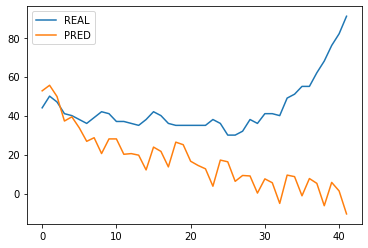

In [40]:
for cod in selCodisReg[-1:]:
    
    print(cod)
    fname = "uci_best_model_region_vacc_mean7.28052021."+cod  

    #Read data
    dfAll = pd.merge(dfInc[["data",'ingressats_critic_r_'+cod,'ingressats_critic_r_'+cod+'_7']],
                     dfVacAll[["data","recompte_r_"+cod+"_v1","recompte_r_"+cod+"_v2",
                               "recompte_r_"+cod+"_v1_7","recompte_r_"+cod+"_v2_7"]], 
                     how="left",on="data",suffixes=("","")
                    )
    dfAll.fillna(0,inplace=True)

    #Remove last day 
    dfAll = dfAll.iloc[:-3]    
    print(dfAll.columns)

    #Convert data to format (rows,timepoints,features)
    cols = [
               'ingressats_critic_r_'+cod, 'ingressats_critic_r_'+cod+'_7', 
               'recompte_r_'+cod+'_v1','recompte_r_'+cod+'_v2', 
               'recompte_r_'+cod+'_v1_7', 'recompte_r_'+cod+'_v2_7'
    ]
    ncols=len(cols)
    res = series_to_supervised(dfAll.loc[:,cols].values,21,21,dropnan=False)
    THR = res.shape[0]-(21*2)    

    #Patition train/test
    train_X = res.iloc[:THR,:(21*ncols)].values.reshape(-1,21,ncols)
    train_y = res.iloc[:THR,[(21*ncols)+(ncols*i) for i in range(21)]].values.reshape(-1,21)
    test_X = res.iloc[THR:,:(21*ncols)].values.reshape(-1,21,ncols)
    test_y = res.iloc[THR:,[(21*ncols)+(ncols*i) for i in range(21)]].values.reshape(-1,21)   
    print(train_X.shape,test_X.shape)

    # normalize features
    scalers_X = []
    for i in range(train_X.shape[-1]):

        # normalize features
        scaler = load(open("models/"+ fname + "_scaler_tr_X_" + str(i)+'.pkl', 'rb'))
        train_X[:,:,i] = scaler.transform(train_X[:,:,i])
        test_X[:,:,i] = scaler.transform(test_X[:,:,i])

    scaler_y = load(open("models/"+ fname + "_scaler_tr_Y.pkl", 'rb'))
    train_y = scaler_y.transform(train_y.reshape(-1,21))
    test_y = scaler_y.transform(test_y.reshape(-1,21))
    tr_y_real = scaler_y.inverse_transform(train_y)  
    ts_y_real = scaler_y.inverse_transform(test_y)
    
    #Evaluate
    tr_y_pred = []
    ts_y_pred = []
    for cc in range(5):
        
        print("Loading...", "models/"+ fname + "_" + str(cc) +'.h5')
        model = tf.keras.models.load_model("models/"+ fname + "_" + str(cc) +'.h5')
        tr = model.predict(train_X)
        ts = model.predict(test_X)
        
        tr_y_pred.append(np.expand_dims(scaler_y.inverse_transform(tr),axis=0))
        ts_y_pred.append(np.expand_dims(scaler_y.inverse_transform(ts),axis=0))
           
    tr_y_pred = np.vstack(tr_y_pred).mean(axis=0)
    ts_y_pred = np.vstack(ts_y_pred).mean(axis=0)
    print(tr_y_pred.shape,ts_y_pred.shape)
    
    #TRAIN
    #Show every 21 days
    tr_y_real_all = tr_y_real[[i for i in range(len(tr_y_real)) if i%21==0],:].flatten()
    tr_y_pred_all = tr_y_pred[[i for i in range(len(tr_y_pred)) if i%21==0],:].flatten()
    plt.plot(range(len(tr_y_real_all)),tr_y_real_all,label="REAL")
    plt.plot(range(len(tr_y_pred_all)),tr_y_pred_all,label="PRED")
    plt.legend()
    plt.show()

    #TEST
    #Show every 21 days
    ts_y_real_all = ts_y_real[[i for i in range(len(ts_y_real)) if i%21==0],:].flatten()
    ts_y_pred_all = ts_y_pred[[i for i in range(len(ts_y_pred)) if i%3==0],:3].flatten()
    plt.plot(range(len(ts_y_real_all)),ts_y_real_all,label="REAL")
    plt.plot(range(len(ts_y_pred_all)),ts_y_pred_all,label="PRED")
    plt.legend()
    plt.show()
        

In [33]:
print(ts_y_pred.mean(axis=0).shape)

(42, 21)
